In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024371.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024358.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024337.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024382.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024420.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024409.jpg
/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024336.jpg
/kaggle/input/skin-cancer/Skin cancer ISI

In [2]:
train_data_path = '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
train_df


,filepaths,label
0,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
1,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
2,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
3,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
4,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
...,...,...
2234,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
2235,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
2236,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
2237,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus


In [4]:
test_data_path = "/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path,fold)
    file_lists = os.listdir(f_path)
    
    
    for file in file_lists:
        filepaths.append(os.path.join(f_path,file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
test_df


,filepaths,label
0,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
1,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
2,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
3,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
4,/kaggle/input/skin-cancer/Skin cancer ISIC The...,pigmented benign keratosis
...,...,...
113,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
114,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
115,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus
116,/kaggle/input/skin-cancer/Skin cancer ISIC The...,nevus


In [6]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)


In [7]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2239 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.


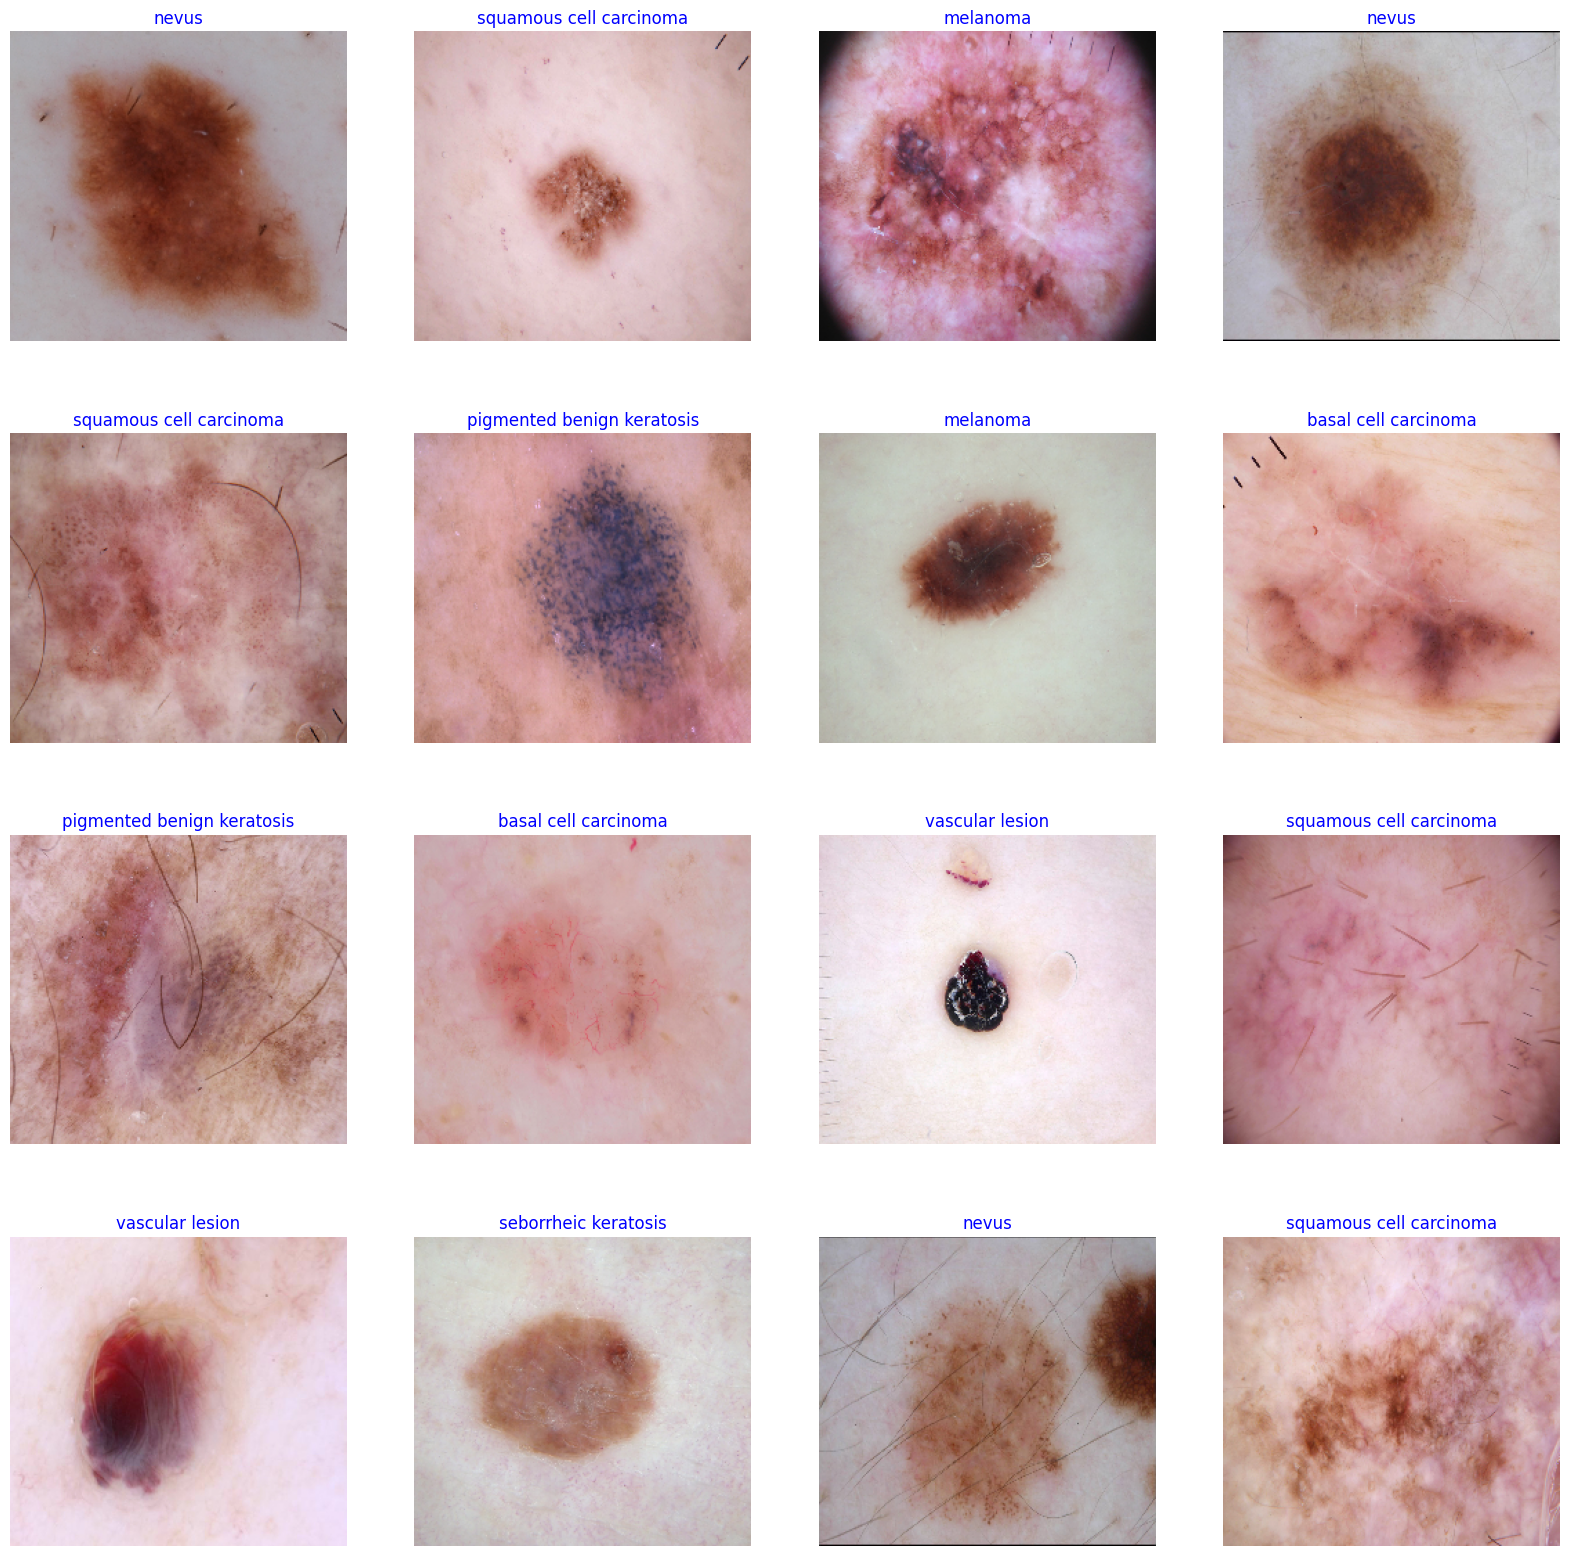

In [8]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='/kaggle/input/vgg-16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification, adjust output units as needed

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Data preparation using ImageDataGenerator (example for binary classification)
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train',  # Replace with your train dataset directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')  # Adjust for multi-class classification if needed

validation_generator = test_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer',  # Replace with your validation dataset directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')  # Adjust for multi-class classification if needed

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size)

# Evaluate the model
evaluation = model.evaluate(validation_generator)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")


Found 2239 images belonging to 9 classes.
Found 2357 images belonging to 1 classes.
Epoch 1/10
69/69 [==============================] - 85s 1s/step - loss: -4419.8188 - accuracy: 0.1666 - val_loss: 4258.8066 - val_accuracy: 0.0089
Epoch 2/10
69/69 [==============================] - 63s 900ms/step - loss: -25890.6406 - accuracy: 0.1679 - val_loss: 16034.6709 - val_accuracy: 0.0089
Epoch 3/10
69/69 [==============================] - 62s 896ms/step - loss: -70077.0625 - accuracy: 0.1679 - val_loss: 36518.9883 - val_accuracy: 0.0089
Epoch 4/10
69/69 [==============================] - 62s 897ms/step - loss: -138722.5625 - accuracy: 0.1679 - val_loss: 65886.9922 - val_accuracy: 0.0089
Epoch 5/10
69/69 [==============================] - 62s 893ms/step - loss: -232556.9062 - accuracy: 0.1679 - val_loss: 104554.2656 - val_accuracy: 0.0089
Epoch 6/10
69/69 [==============================] - 63s 899ms/step - loss: -352560.3438 - accuracy: 0.1679 - val_loss: 152550.0781 - val_accuracy: 0.0089
Epoc

In [20]:
batch_size = 32  # Define the batch size for training and evaluation


In [21]:
# Flow training, validation, and test images in batches using respective data generators
train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 2357 images belonging to 1 classes.
Found 118 images belonging to 9 classes.


In [22]:
image_height = 224  # Define the height of the images
image_width = 224   # Define the width of the images


In [23]:
# Flow training, validation, and test images in batches using respective data generators
train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 2357 images belonging to 1 classes.
Found 118 images belonging to 9 classes.


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define and configure ImageDataGenerators for training, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)   # Test data shouldn't be augmented

# Flow training, validation, and test images in batches using respective data generators
train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    '/kaggle/input/skin-cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Now you can use these generators to evaluate your model
train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)


Found 2239 images belonging to 9 classes.
Found 2357 images belonging to 1 classes.
Found 118 images belonging to 9 classes.
16/16 [==============================] - 6s 337ms/step - loss: 2.1972 - accuracy: 0.2561


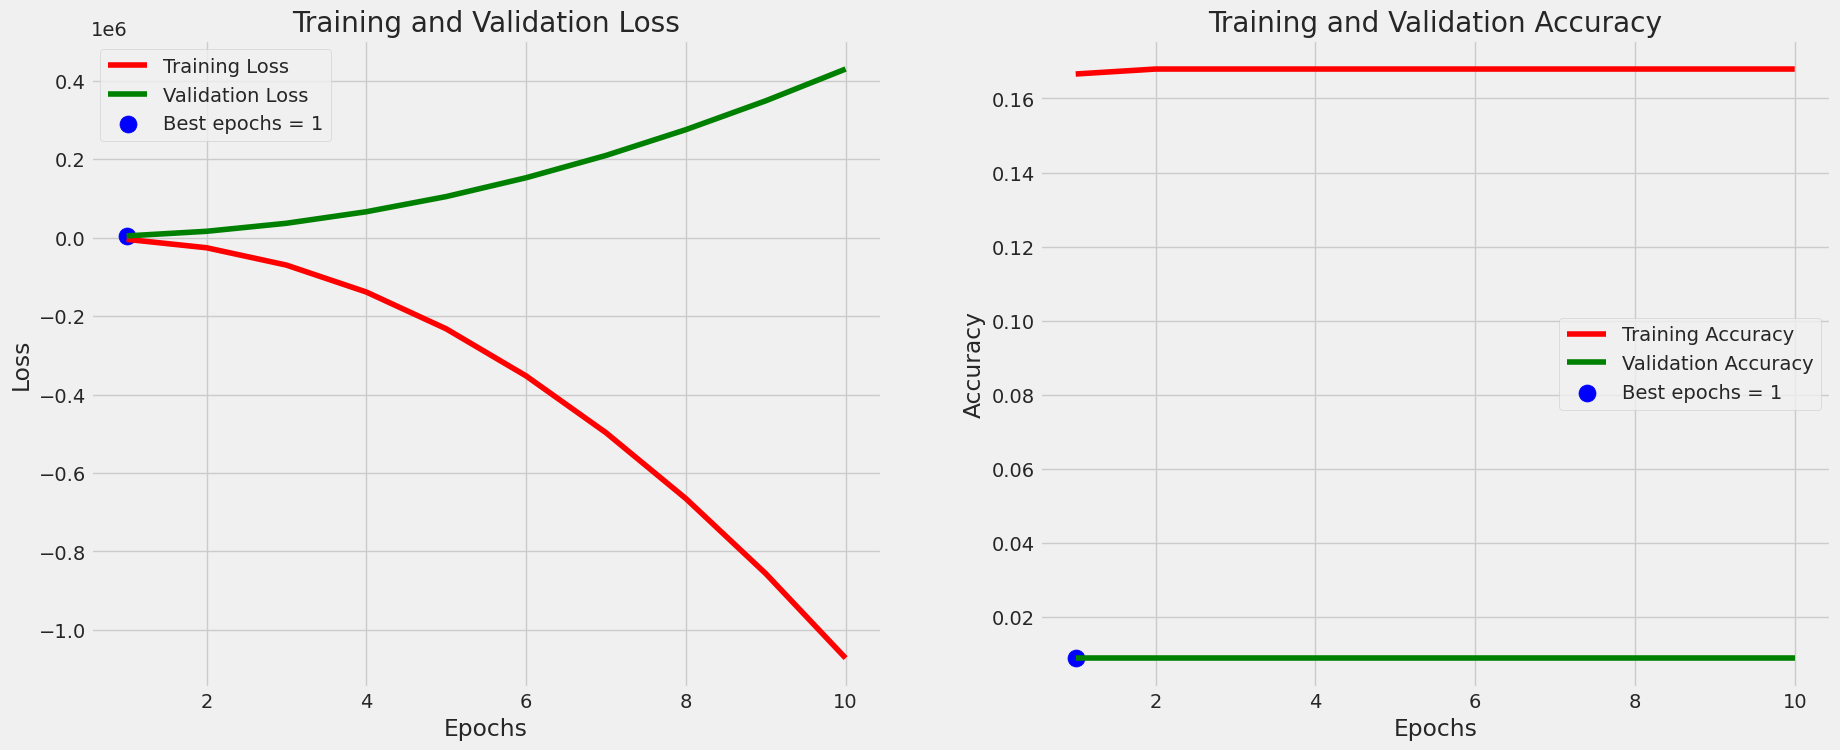

In [25]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [26]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 4s 238ms/step - loss: 2.1972 - accuracy: 0.2561
Train Loss:  2.1972241401672363
Train Accuracy:  0.11111113429069519
--------------------
Validation Loss:  0.0
Validation Accuracy:  1.0
--------------------
Test Loss:  2.1972248554229736
Test Accuracy:  0.2561205327510834


In [27]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

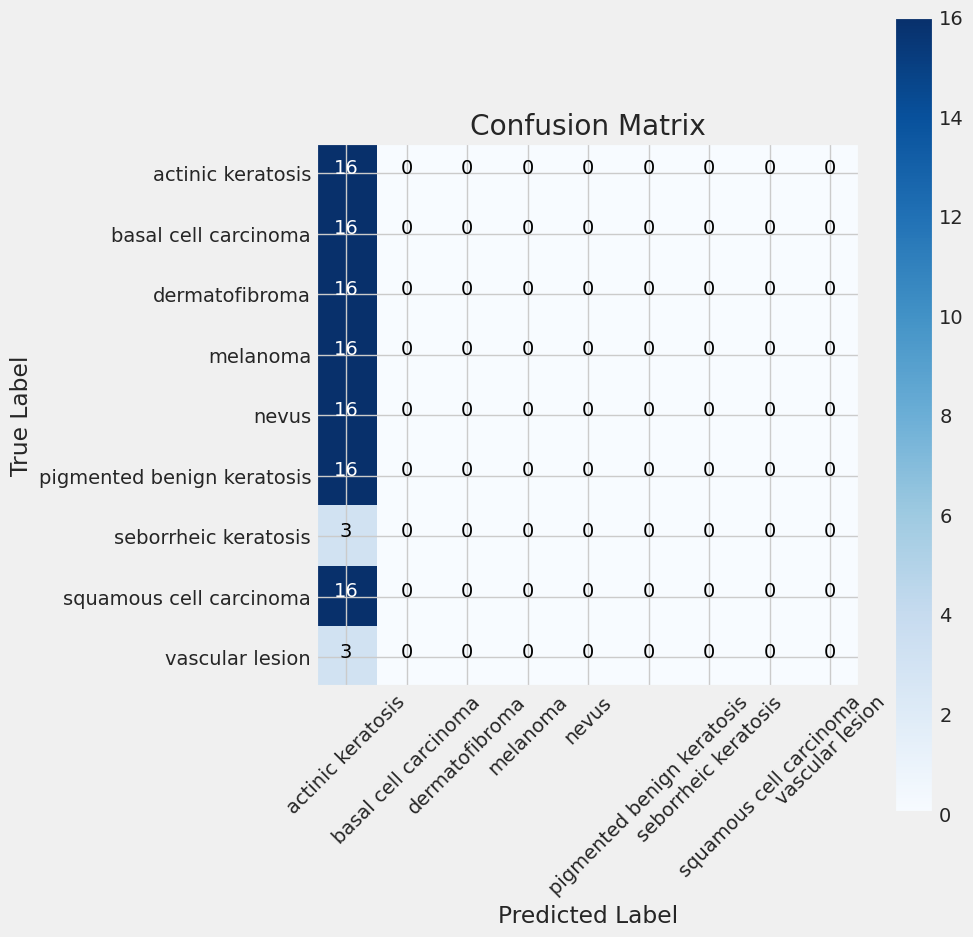

In [32]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [33]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

                            precision    recall  f1-score   support

         actinic keratosis       0.14      1.00      0.24        16
      basal cell carcinoma       0.00      0.00      0.00        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.00      0.00      0.00        16
pigmented benign keratosis       0.00      0.00      0.00        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.14       118
                 macro avg       0.02      0.11      0.03       118
              weighted avg       0.02      0.14      0.03       118

